# Model Explainability: Visualizing "Curb Appeal"

This notebook reveals what the **Deep Learning Fusion Model** actually "sees" when valuing a property. We use **Grad-CAM** (Gradient-weighted Class Activation Mapping) to overlay an attention heatmap on satellite imagery, highlighting positive (e.g., green space) and negative (e.g., industrial) drivers of value.

In [42]:
import os
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from torchvision import models, transforms
from PIL import Image
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
import warnings
warnings.filterwarnings('ignore')

# Style
plt.style.use('seaborn-v0_8-white')
plt.rcParams['font.family'] = 'sans-serif'

# Config
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
MODEL_PATH = "../outputs/best_model.pth"
IMAGE_DIR = "../data/images"
DATA_PATH = "../data/processed/val.csv"
SAVE_DIR = "../assets"
os.makedirs(SAVE_DIR, exist_ok=True)

print(f"Running on {DEVICE}")

Running on cpu


In [43]:
# --- Model Architecture (ResNet + MLP Fusion) ---
class FusionModel(nn.Module):
    def __init__(self, num_tabular_features=18):
        super(FusionModel, self).__init__()
        # Vision Branch (ResNet18)
        self.resnet = models.resnet18(weights=None)
        self.resnet.fc = nn.Identity()
        
        # Tabular Branch (MLP)
        self.mlp = nn.Sequential(
            nn.Linear(num_tabular_features, 128),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.ReLU()
        )
        
        # Fusion Layer
        self.head = nn.Sequential(
            nn.Linear(512 + 64, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 1)
        )

    def forward(self, img, tab):
        v = self.resnet(img)
        t = self.mlp(tab)
        return self.head(torch.cat((v, t), dim=1))

# Load Weights
print("Loading trained weights...")
model = FusionModel(num_tabular_features=18).to(DEVICE)
model.load_state_dict(torch.load(MODEL_PATH, map_location=DEVICE))
model.eval()
print("Model loaded.")

Loading trained weights...
Model loaded.


In [44]:
# --- Grad-CAM Wrapper ---
class ModelWrapper(nn.Module):
    def __init__(self, model, tabular_input):
        super().__init__()
        self.model = model
        self.tabular_input = tabular_input
    def forward(self, img):
        return self.model(img, self.tabular_input)

# Image Transform
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

def visualize_property(row_idx, df):
    row = df.iloc[row_idx]
    img_path = os.path.join(IMAGE_DIR, f"{int(row['id'])}.png")
    
    if not os.path.exists(img_path):
        print(f"Skipping {row['id']} (Image not found)")
        return

    # Prepare Data
    img_pil = Image.open(img_path).convert('RGB').resize((224, 224))
    img_tensor = transform(img_pil).unsqueeze(0).to(DEVICE)
    img_norm = np.array(img_pil).astype(np.float32) / 255.0
    
    # Tabular Data
    features = ['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 
                'view', 'condition', 'grade', 'sqft_above', 'sqft_basement', 
                'yr_built', 'yr_renovated', 'lat', 'long', 'sqft_living15', 
                'sqft_lot15', 'house_age', 'zipcode_mean']
    tab_tensor = torch.tensor(row[features].values.astype(np.float32)).unsqueeze(0).to(DEVICE)

    # Grad-CAM
    wrapper = ModelWrapper(model, tab_tensor)
    target_layer = [model.resnet.layer4[-1]]
    cam = GradCAM(model=wrapper, target_layers=target_layer)
    grayscale_cam = cam(input_tensor=img_tensor)[0]
    visualization = show_cam_on_image(img_norm, grayscale_cam, use_rgb=True)

    # Plotting
    price = np.expm1(row['price_log'])
    
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))
    
    # Original
    ax[0].imshow(img_pil)
    ax[0].set_title("Satellite View", fontsize=14, fontweight='bold', pad=10)
    ax[0].axis('off')
    
    # Explainability
    ax[1].imshow(visualization)
    ax[1].set_title("AI Model Attention (Heatmap)", fontsize=14, fontweight='bold', pad=10)
    ax[1].axis('off')
    
    plt.suptitle(f"Property Valuation: ${price:,.0f}\nLocation: {int(row['zipcode'])}", 
                 fontsize=16, fontweight='heavy', y=0.95)
    plt.tight_layout()
    plt.show()

## Results: Analyzing Diverse Properties

Analyzing High-Value Property (Top 10%)...


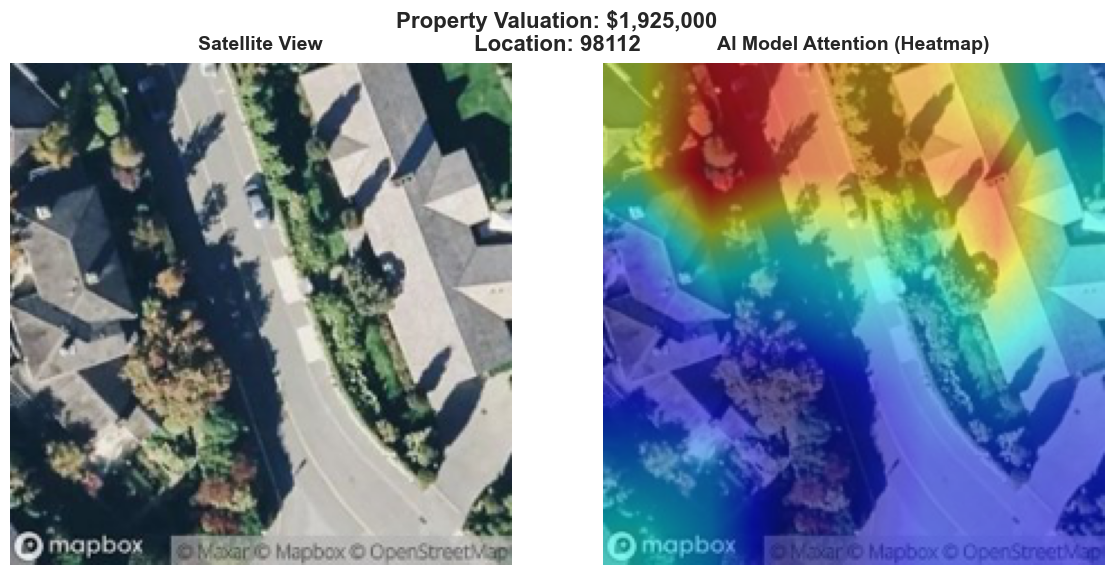


Analyzing Median-Value Property...


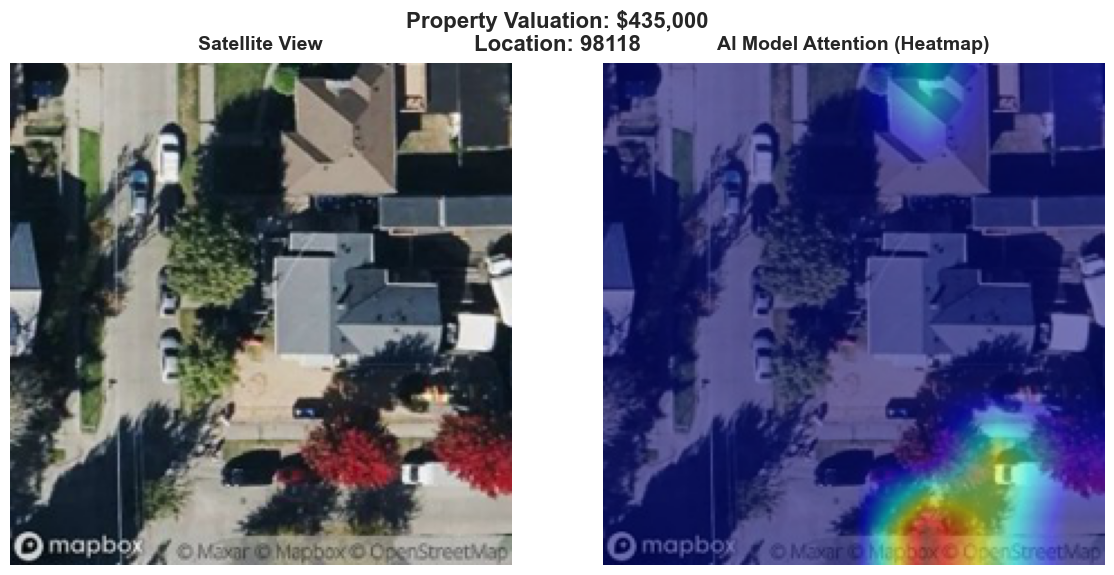


Analyzing Low-Value Property (Bottom 10%)...


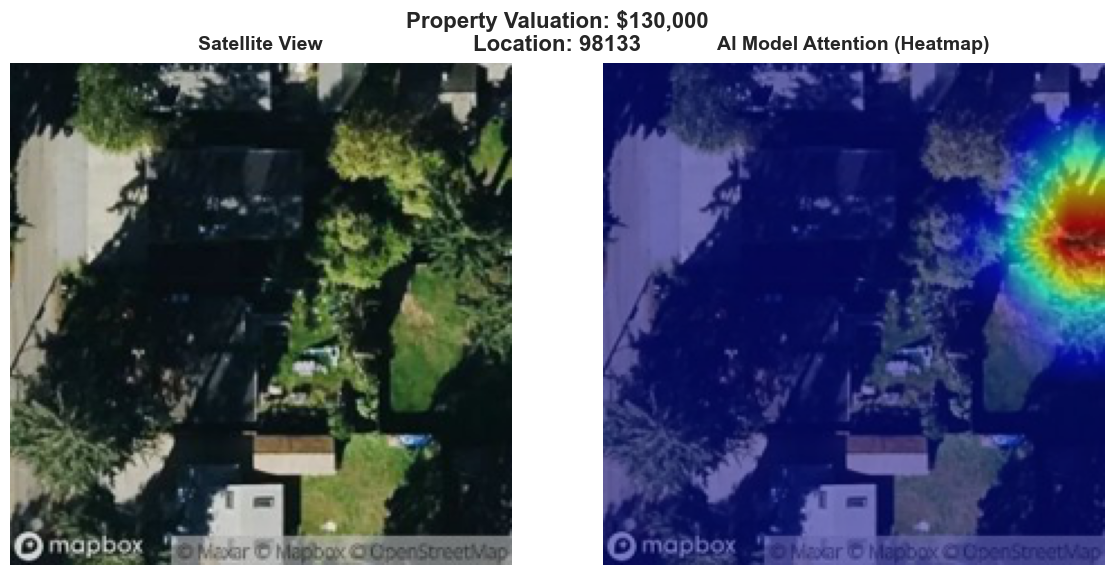

In [45]:
df = pd.read_csv(DATA_PATH)

# Visualize Top 10% (High Value) vs Bottom 10% (Low Value)
print("Analyzing High-Value Property (Top 10%)...")
visualize_property(df['price_log'].argmax(), df)

print("\nAnalyzing Median-Value Property...")
median_idx = (df['price_log'] - df['price_log'].median()).abs().argsort()[:1].values[0]
visualize_property(median_idx, df)

print("\nAnalyzing Low-Value Property (Bottom 10%)...")
visualize_property(df['price_log'].argmin(), df)